# Part 2 - Regression

In [6]:
import pandas as pd

df = pd.read_csv("data/submissions.csv")
target = "rank"

In [10]:
# NOTE: These helper functions were taken from the matplotlib annotated heatmap tutorial https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
import matplotlib
import numpy as np
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current Axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(range(data.shape[1]), labels=col_labels,
                  rotation=-30, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

#### EDA to find collinear features

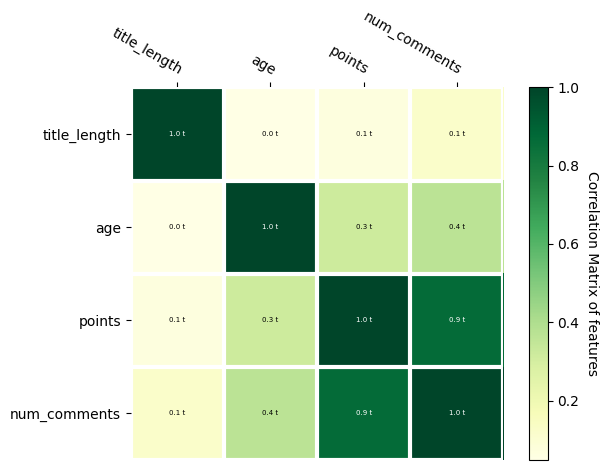

In [11]:
import matplotlib.pyplot as plt

features = ["title_length", "age", "points", "num_comments"]

corr_mat = df[features].corr()

fig, ax = plt.subplots()

im, cbar = heatmap(corr_mat[features], corr_mat.index, corr_mat.columns, ax=ax,
                   cmap="YlGn", cbarlabel="Correlation Matrix of features")
texts = annotate_heatmap(im, valfmt="{x:.1f} t", fontsize=5)

fig.tight_layout()
plt.show()

In [13]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[features]
X = sm.add_constant(X)

vif_df = pd.DataFrame()
vif_df["feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_df

,feature,VIF
0,const,15.145576
1,title_length,1.019958
2,age,1.156318
3,points,3.955727
4,num_comments,4.152799


##### Notes on collinearity

The number of comments and points are highly correlated. However, no feature has a concerning VIF score (i.e. > 5 or so). Thus, attempting an OLS model with all features could be a potential approach. Additionally, there are no inverse relationships to worry about.


In [14]:
# Fit multiple models
feature_sets = {
    "model_1": features, # All features available
    "model_2": ["title_length", "age", "points"], # Exclude num_comments which has highest VIF
    "model_3": ["title_length", "age", "num_comments"], # Exclude points which has second highest VIF
}

models = {}
for model_name, feat in feature_sets.items():
    x = df[feat]
    x = sm.add_constant(x)
    y = df[target]
    model = sm.OLS(y, x).fit()
    models[model_name] = model
    print(f"MODEL: {model_name}\n")
    print(model.summary())
    print("\n")

MODEL: model_1

                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     29.00
Date:                Sat, 07 Jun 2025   Prob (F-statistic):           1.11e-17
Time:                        19:25:15   Log-Likelihood:                -728.59
No. Observations:                 149   AIC:                             1467.
Df Residuals:                     144   BIC:                             1482.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           21.7411     10.4

#### Regression summary

All models share a similar R-squared ranging from 0.418 to 0.446.
age seems to have the largest impact on all models, which intuitively makes sense as the longer the post is around the more time it's given to gain engagement and upvotes.
The first model shows num_comments as being statistically insignificant, however, the 3rd model that includes num comments does show it tobe significant. This could be due to the inclusion of points in the first model which is fairly correlated with num comments.
In the first and second model, points seems to have a minimal impact on rank.


## Part 3 Classification

In [29]:
df['rank_class'] = df['rank'].apply(lambda rank: int(rank <= 30)) # Front page contains ranks up to 30

In [30]:
print(df['rank_class'].value_counts())

rank_class
0    120
1     29
Name: count, dtype: int64


<Axes: xlabel='age', ylabel='rank_class'>

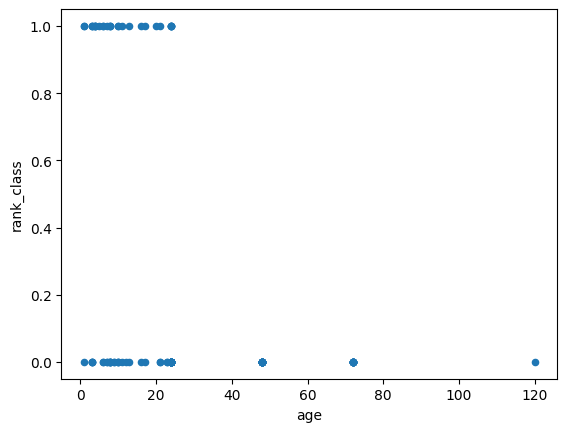

In [31]:
df.plot.scatter(x='age', y='rank_class')

In [37]:
df[df['rank_class'] == 1].shape

(29, 6)

In [38]:
balanced_df = pd.concat([df[df['rank_class'] == 1], df[df['rank_class'] == 0].sample(df[df['rank_class'] == 1].shape[0])])


<Axes: xlabel='age', ylabel='rank_class'>

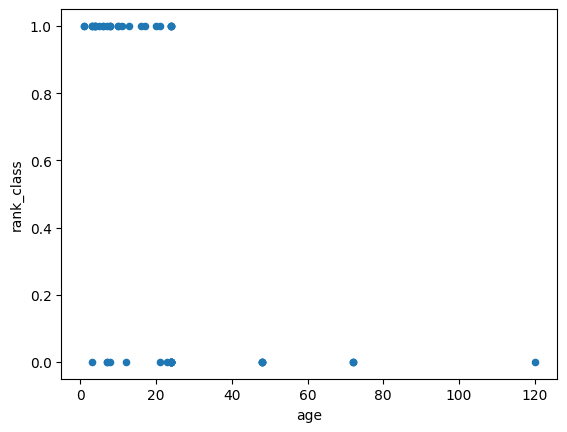

In [40]:
balanced_df.plot.scatter(x='age', y='rank_class')